# Image Classification using Keras
In this notebook I'll be creating image classification models with images found in Zalando's articles which can be found posted on Kaggle. 
<br/>https://www.kaggle.com/zalando-research/fashionmnist<br/><br/>
The images are 28x28 pixel grayscale images- similar to the MNIST hand-written dataset. I'll be creating several neural nets to see which are the most effective in this context.<br/><br/>
After the classification models, I'll explore generative models (GANs) to see if we're able to generate new images that our models haven't seen.

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

from keras.models import Model, Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Conv2D, \
                            MaxPooling2D, Reshape, BatchNormalization, MaxPool2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Convolution2D, UpSampling2D
from keras.callbacks import EarlyStopping
from keras import initializers
import tensorflow as tf

os.environ['KERAS_BAKEND'] = 'tensorflow'
%matplotlib inline

# Import Data

In [24]:
# Import train and test data.
trainFile = 'fashionmnist/fashion-mnist_train.csv'
testFile = 'fashionmnist/fashion-mnist_test.csv'

# Create dataframes and X(feature) matrix and target vector
df_train = pd.read_csv(trainFile)
df_test = pd.read_csv(testFile)

X_train = df_train.drop('label', axis=1)
y_train = df_train['label']

X_test = df_test.drop('label', axis=1)
y_test = df_test['label']

# Normalize data to 0 - 1 scale
X_train = X_train / 255
X_test = X_test / 255

# Transform dataframes into arrays
X_train_arr = X_train.values
X_test_arr = X_test.values

# One hot encode target vectors
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [3]:
# What the training data looks like.
df_train.head(5)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# EDA

In [25]:
label_num = len(set(df_train['label']))
pixel_num = X_train.shape[1]

print('Training set number of images: ', X_train.shape[0])
print('Test set number of images: ', X_test.shape[0])
print('')
print('Categories: ', set(df_train['label']))
print('')
print('Number of images per category in training set:')
print(df_train.groupby('label').count().iloc[:,0])

Training set number of images:  60000
Test set number of images:  10000

Categories:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

Number of images per category in training set:
label
0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
Name: pixel1, dtype: int64


Training set contains 60,000 images- 6000 images per each of the 10 categories. The test set contains 10,000 images.

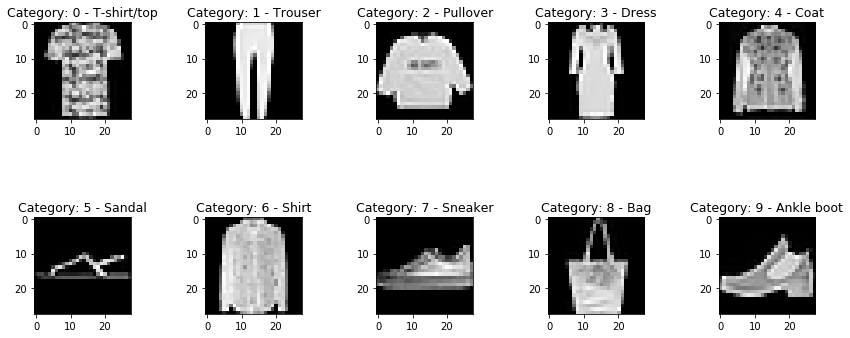

In [26]:
def printImg(index):
    '''This function takes an index as a parameter and returns the image 
        in the dataframe df_train with the corresponding index number.'''
    imgRow = df_train[df_train['label'] == index].iloc[0, 1:].values
    plt.imshow(imgRow.reshape(28,28), cmap=plt.get_cmap('gray'))


fig = plt.figure(figsize=(12, 12))

class_dct = {0:'T-shirt/top',
             1:'Trouser',
             2:'Pullover',
             3:'Dress',
             4:'Coat',
             5:'Sandal',
             6:'Shirt',
             7:'Sneaker',
             8:'Bag',
             9:'Ankle boot'
}

# Print an image of each category- 5 per line.
fig = plt.figure(figsize=(12, 12))

for i in range(5):
    fig.add_subplot(2, 5, i+1)
    plt.title('Category: ' + str(i) + ' - ' + class_dct[i], fontsize=12.5)
    printImg(i)

for i in range(5, 10):
    fig.add_subplot(1, 5, i-4)
    plt.title('Category: ' + str(i) + ' - ' + class_dct[i], fontsize=12.5)
    printImg(i)

plt.tight_layout()

Visually inspecting these images there seems to be overlapping features in some categories. For example, categories 0 and 4 as well as categories 7 and 9 may be mistaken for each other.

# Modeling


First we'll experiment with different types of Sequential neural nets and optimize on topology and epochs. 

### Model 1: Neural Net

In [144]:
# Model parameters
np.random.seed(1337)
epochs = 50
batch_num = 10
batch_size = int(X_train.shape[0] / batch_num)

In [155]:
model_1 = Sequential()
model_1.add(Dense(300, activation='relu', input_dim=pixel_num))
model_1.add(Dense(10, activation='softmax'))

model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit Model with EarlyStopping
early_stopping_monitor = EarlyStopping(patience=3)
history_nn = model_1.fit(X_train_arr, y_train, validation_data=(X_test_arr, y_test), epochs=epochs, batch_size=batch_size, 
          callbacks=[early_stopping_monitor], verbose=0)


In [156]:
print('Number of Epochs, ', len(history_nn.history['acc']))
print('Validation Accuracy: ', max(history_nn.history['val_acc']))

Number of Epochs,  50
Validation Accuracy:  0.888800001144


We used 'EarlyStopping' for the first model. This is a callback function in keras that stops the training process when the accuracy score doesn't improve after a given amount of epochs (in this case 3). In other words since the above model stopped at 44 epochs, that shows the accuracy didn't improve after training through the 45th, 46th, and 47th epochs.

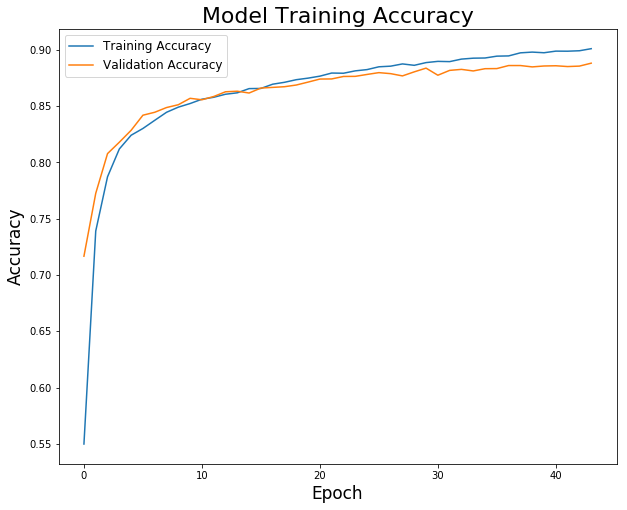

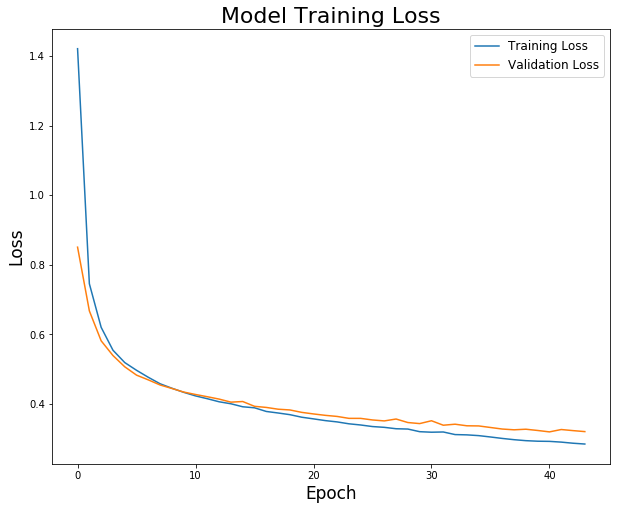

In [49]:
# Model Fitting Accuracy
plt.figure(figsize=(10,8))
plt.plot(history_nn.history['acc'])
plt.plot(history_nn.history['val_acc'])
plt.title('Model Training Accuracy', fontsize=22)
plt.xlabel('Epoch', fontsize=17)
plt.ylabel('Accuracy', fontsize=17)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=12)
plt.show()

# Model Fitting Loss
plt.figure(figsize=(10,8))
plt.plot(history_nn.history['loss'])
plt.plot(history_nn.history['val_loss'])
plt.title('Model Training Loss', fontsize=22)
plt.xlabel('Epoch', fontsize=17)
plt.ylabel('Loss', fontsize=17)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=12)
plt.show()

At the 25th epoch, the training and validation accuracy and loss scores look like they're starting to diverge. The training metrics continue to improve, but not on the validation data. <br/><br/>
Let's run the model through 100 epochs to see what the accuracy and loss would look like.

In [50]:
# Recreate Sequential model above with same topology but train for 100 epochs
model = Sequential()
model.add(Dense(300, activation='relu', input_dim=pixel_num))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train_arr, y_train, validation_data=(X_test_arr, y_test), epochs=100, batch_size=batch_size, verbose=0)

In [52]:
print('Training Accuracy: ', max(history.history['acc']))
print('Validation Accuracy: ', max(history.history['val_acc']))

Training Accuracy:  0.932166671753
Validation Accuracy:  0.897699999809


The validation accuracy increased by ~0.01 by training the model through 66 more epochs.

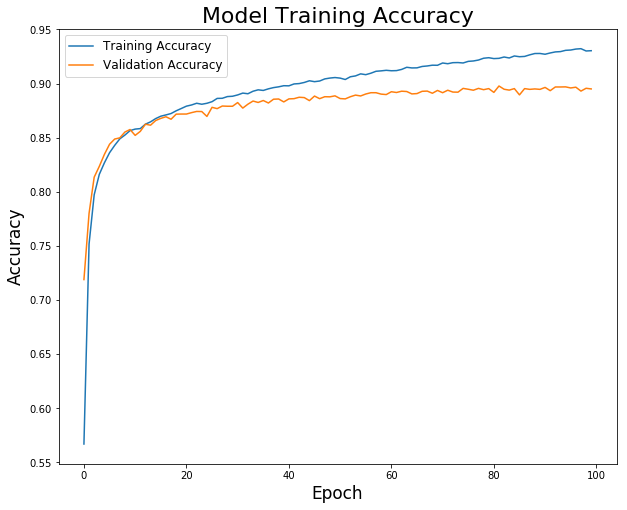

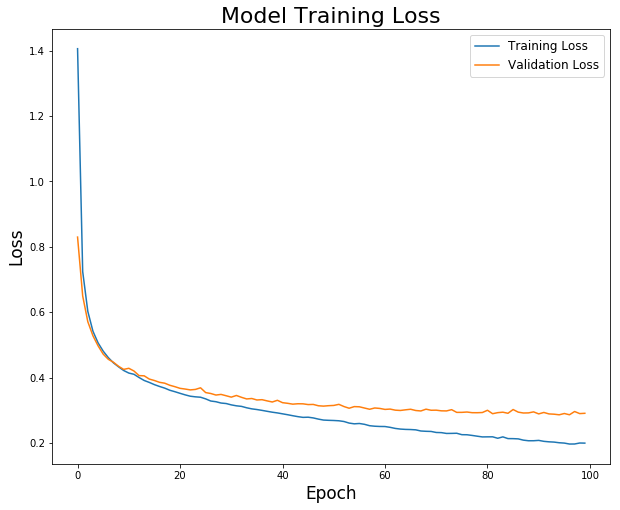

In [53]:
# Epoch Fitting Accuracy
plt.figure(figsize=(10,8))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Training Accuracy', fontsize=22)
plt.xlabel('Epoch', fontsize=17)
plt.ylabel('Accuracy', fontsize=17)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=12)
plt.show()

# Model Fitting Loss
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Training Loss', fontsize=22)
plt.xlabel('Epoch', fontsize=17)
plt.ylabel('Loss', fontsize=17)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=12)
plt.show()

Past ~25 epochs is when the validation accuracy and loss seems to taper off and not provide better scores. That's also the point where the training and validation scores start to diverge which would lead to an overfit model. 

### Neural Net Topology Optimization
Experimenting with number of layers/neurons.

In [76]:
epochs = 25

def instantiate_nn(layers, neurons):
    '''This function takes the number of layers and neurons as parameters and creates
    a Sequential model. This will only work for layer inputs 1, 2, and 3.'''
    if layers == 1:
        model = Sequential()
        model.add(Dense(neurons, activation='relu', input_dim=pixel_num))
        model.add(Dense(10, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        history = model.fit(X_train_arr, y_train, validation_data=(X_test_arr, y_test), epochs=epochs, batch_size=batch_size, verbose=0)
        return history
    elif layers == 2:
        model = Sequential()
        model.add(Dense(neurons, activation='relu', input_dim=pixel_num))
        model.add(Dense(neurons, activation='relu', input_dim=pixel_num))
        model.add(Dense(10, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        history = model.fit(X_train_arr, y_train, validation_data=(X_test_arr, y_test), epochs=epochs, batch_size=batch_size, verbose=0)
        return history
    elif layers == 3:
        model = Sequential()
        model.add(Dense(neurons, activation='relu', input_dim=pixel_num))
        model.add(Dense(neurons, activation='relu', input_dim=pixel_num))
        model.add(Dense(10, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        history = model.fit(X_train_arr, y_train, validation_data=(X_test_arr, y_test), epochs=epochs, batch_size=batch_size, verbose=0)
        return history
    else:
        return 'Need to input 1, 2, or 3 layers'

nn_1_50 = instantiate_nn(1, 50)
nn_1_200 = instantiate_nn(1, 200)
nn_1_800 = instantiate_nn(1, 800)
nn_2_300 = instantiate_nn(2, 300)
nn_3_300 = instantiate_nn(3, 300)
nn_2_400 = instantiate_nn(2, 400)
nn_2_200 = instantiate_nn(2, 200)

In [139]:
neural_nets_str_list = ['nn_1_50', 'nn_1_200', 'nn_1_800', 'nn_2_300', 'nn_3_300', 'nn_2_400', 'nn_2_200']
neural_nets_list = [nn_1_50, nn_1_200, nn_1_800, nn_2_300, nn_3_300, nn_2_400, nn_2_200]
neural_nets_val_acc = [max(nn.history['val_acc']) for nn in neural_nets_list]

# Adding model with 1 layer and 300 neurons from above
neural_nets_str_list.append('nn_1_300')
neural_nets_val_acc.append(max(history_nn.history['val_acc']))

# Make dataframe to sort and view
neural_nets_df = pd.DataFrame(neural_nets_str_list, columns=['nn_name'])
neural_nets_df['val_acc'] = neural_nets_val_acc

neural_nets_df.sort_values('val_acc', ascending=False)

,nn_name,val_acc
7,nn_1_300,0.8888
5,nn_2_400,0.8873
3,nn_2_300,0.8864
4,nn_3_300,0.8858
2,nn_1_800,0.8835
6,nn_2_200,0.8803
1,nn_1_200,0.8698
0,nn_1_50,0.8601


The breakdown in the above dataframe shows our initial model (1 hidden layer, 300 neurons) was the best performing- but not by much. With our epoch analysis, I don't expect any of the models to perform much better through more training so we'll accept the neural net validation accuracy caps at around 88% for now.

Let's run a classification report on the initial model to see performance by category.

### Classification Report

In [157]:
predict_test = model_1.predict_classes(X_test_arr)

target_names = []
for k, v in class_dct.items():
    target_names.append(v)

print(classification_report(np.array(df_test['label']), predict_test, target_names=target_names))

10000/10000 [==============================] - 1s 67us/step
             precision    recall  f1-score   support

T-shirt/top       0.79      0.89      0.84      1000
    Trouser       0.98      0.98      0.98      1000
   Pullover       0.83      0.80      0.82      1000
      Dress       0.91      0.90      0.90      1000
       Coat       0.78      0.89      0.84      1000
     Sandal       0.97      0.93      0.95      1000
      Shirt       0.80      0.61      0.70      1000
    Sneaker       0.92      0.93      0.92      1000
        Bag       0.96      0.96      0.96      1000
 Ankle boot       0.93      0.97      0.95      1000

avg / total       0.89      0.89      0.89     10000



**Ranking accuracy by category,** <br/>
1. Trouser <br/>
2. Bag <br/>
3. Sandal <br/>
4. Ankle boot <br/>
5. Sneaker <br/>
6. Dress <br/>
7. T-shirt/top <br/>
8. Coat <br/>
9. Pullover <br/>
10. Shirt <br/>

Unsurprisingly the best accuracy were on categories that were the most distinct. By distinct I'm pertaining to 'uniqueness' from other categories ie: bags which don't look like shirts or pants.<br/><br/> The worst accuracy were on categories where they could be seen to overlap with another category (ie: T-shirt/top and Shirt). <br/><br/>
Let's try this again with a convolutional neural net which I expect will help pick up with subtleties in the differences between some of the categories.

### Model 2: Convolutional Neural Net

In [158]:
# Reshape pixel matrix to 3 dimensional matrix
X_train_cnn = X_train.values.reshape(X_train.shape[0], 28, 28, 1)
X_test_cnn = X_test.values.reshape(X_test.shape[0], 28, 28, 1)

We'll create a CNN with 2 convolution layers.

In [172]:
# Instantiate and compile model
model_cnn = Sequential()

model_cnn.add(Conv2D(15, (5, 5), input_shape=(28, 28, 1), activation='relu')) 
model_cnn.add(MaxPool2D((2, 2)))
model_cnn.add(Conv2D(30, (4, 4), activation='relu'))
model_cnn.add(MaxPool2D((2, 2)))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(10, activation='softmax'))

model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_cnn = model_cnn.fit(X_train_cnn, y_train, validation_data=(X_test_cnn, y_test), \
                            batch_size=batch_size, epochs=30, verbose=0)

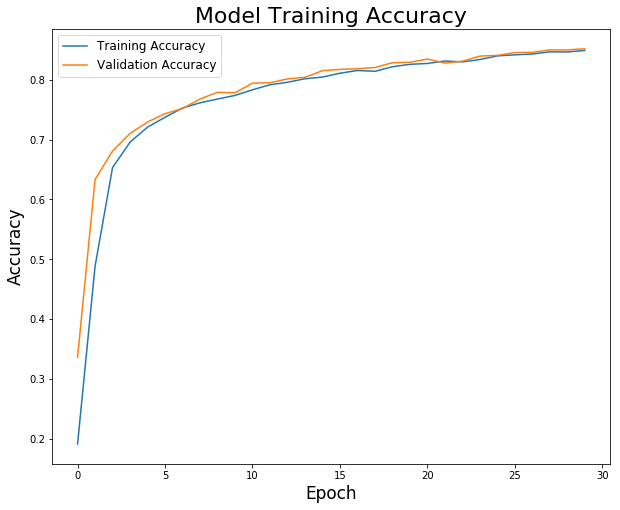

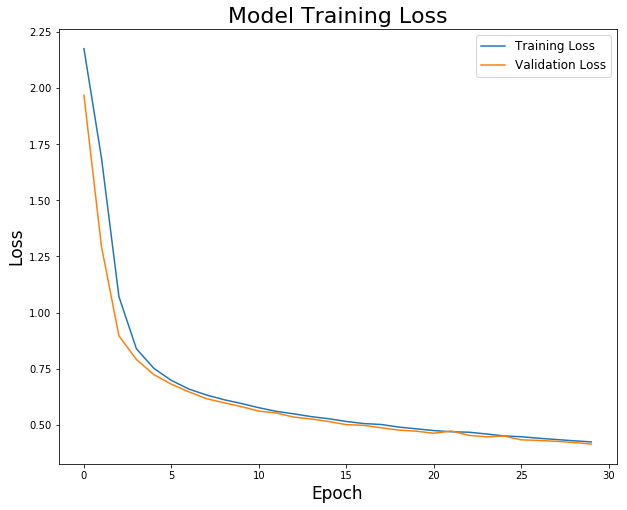

In [160]:
# Epoch Fitting Accuracy
plt.figure(figsize=(10,8))
plt.plot(history_cnn.history['acc'])
plt.plot(history_cnn.history['val_acc'])
plt.title('Model Training Accuracy', fontsize=22)
plt.xlabel('Epoch', fontsize=17)
plt.ylabel('Accuracy', fontsize=17)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=12)
plt.show()

# Model Fitting Loss
plt.figure(figsize=(10,8))
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Model Training Loss', fontsize=22)
plt.xlabel('Epoch', fontsize=17)
plt.ylabel('Loss', fontsize=17)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=12)
plt.show()

The accuracy and loss looks like its doing a good job at quickly increasing its performance in a few epochs, but then plateaus hard at ~80% accuracy similar to that of the first neural nets.

In [162]:
model_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 15)        390       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 15)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 30)          7230      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 480)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 50)                24050     
_________________________________________________________________
dense_58 (Dense)             (None, 50)                2550      
__________

In [164]:
# Test accuracy score
test_accuracy = model_cnn.evaluate(X_test_cnn, y_test)
print('test loss:', test_accuracy[0])
print('test accuracy:', test_accuracy[1])

10000/10000 [==============================] - 2s 157us/step
test loss: 0.414366408992
test accuracy: 0.8521


Suprisingly running the images through a CNN didn't improve accuracy scores from the initial neural nets- it actually performed worse. <br/><br/>
I would like to play around with the CNN topology and optimize on its accuracy, but will do so at another time to mitigate this notebook becoming too long.

**Conclusions**<br/>
Given this particular dataset, I can see why the models are having a hard time achieving an accuracy score > 90%. Even viewing these images with our eyes, it's hard to distinguish between some categories.

Both look like shirts!!


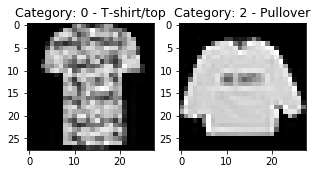

In [174]:
fig = plt.figure(figsize=(5, 5))

fig.add_subplot(1, 2, 1)
plt.title('Category: 0 - T-shirt/top', fontsize=12.5)
printImg(0)

fig.add_subplot(1, 2, 2)
plt.title('Category: 2 - Pullover', fontsize=12.5)
printImg(2)

print('Both look like shirts!!')

# Bonus Model
# Model 3 - Binary Classification
**Kept for the submission of the Capstone (being the project title was 'Not Pants')

In [54]:
# Create new target vector with whether the image is pants or not pants
y_train_pants = df_train['label'].map(lambda x: 1 if x==1 else 0)
y_test_pants = df_test['label'].map(lambda x: 1 if x==1 else 0)

In [57]:
# Use same topology as CNN above, but change to binary classification activation and loss 
# function
model_pants = Sequential()

model_pants.add(Conv2D(15, (5, 5), input_shape=(28, 28, 1), activation='relu')) 
model_pants.add(MaxPool2D((2, 2)))
model_pants.add(Conv2D(30, (4, 4), activation='relu'))
model_pants.add(MaxPool2D((2, 2)))
model_pants.add(Flatten())
model_pants.add(Dense(50, activation='relu'))
model_pants.add(Dense(50, activation='relu'))
model_pants.add(Dense(1, activation='sigmoid'))

model_pants.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_pants = model_pants.fit(X_train_cnn, y_train_pants, validation_data=(X_test_cnn, y_test_pants), \
                                batch_size=200, epochs=20, verbose=0)

In [59]:
# Test accuracy score
test_accuracy = model_pants.evaluate(X_test_cnn, y_test_pants)
print('test loss:', test_accuracy[0])
print('test accuracy:', test_accuracy[1])

10000/10000 [==============================] - 2s 156us/step
test loss: 0.00880591457183
test accuracy: 0.9978


# GANs
### Current work in progress!

In [183]:
y_train_arr = df_train['label'].values

# Parameters
dimensionality = 100
dropout = 0.25

In [184]:
# Instantiate generator
generator = Sequential()
generator.add(Dense(256, input_dim=dimensionality, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))

generator.add(Dense(512))
generator.add(LeakyReLU(0.2))

generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))

generator.add(Dense(784, activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer='adam')

# Instantiate discriminator
discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=X_train_arr.shape[1], kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(dropout))

discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(dropout))

discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(dropout))

discriminator.add(Dense(1, activation='sigmoid'))

discriminator.compile(loss='binary_crossentropy', optimizer='adam')

# Combine network
discriminator.trainable = False
gan_input = Input(shape=(dimensionality,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = Model(inputs=gan_input, outputs=gan_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')

In [185]:
# GAN parameter tuning happens here
epochs = 200
batch_size = int(X_train_arr.shape[1] / 4)
batch_num = int(X_train_arr.shape[1] / batch_size)
dLosses = []
gLosses = []

Sanity check- current epoch: 1
Sanity check- current epoch: 50
Sanity check- current epoch: 100
Sanity check- current epoch: 150
Sanity check- current epoch: 200


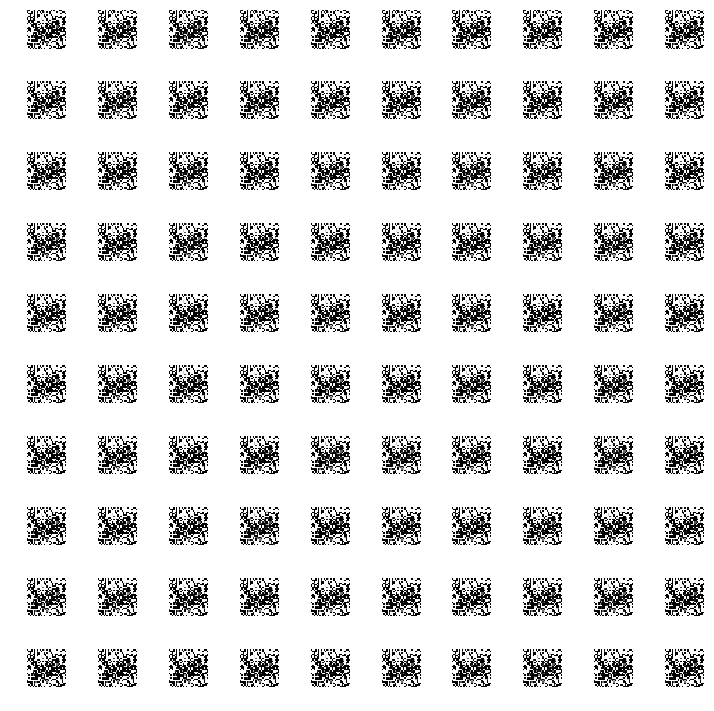

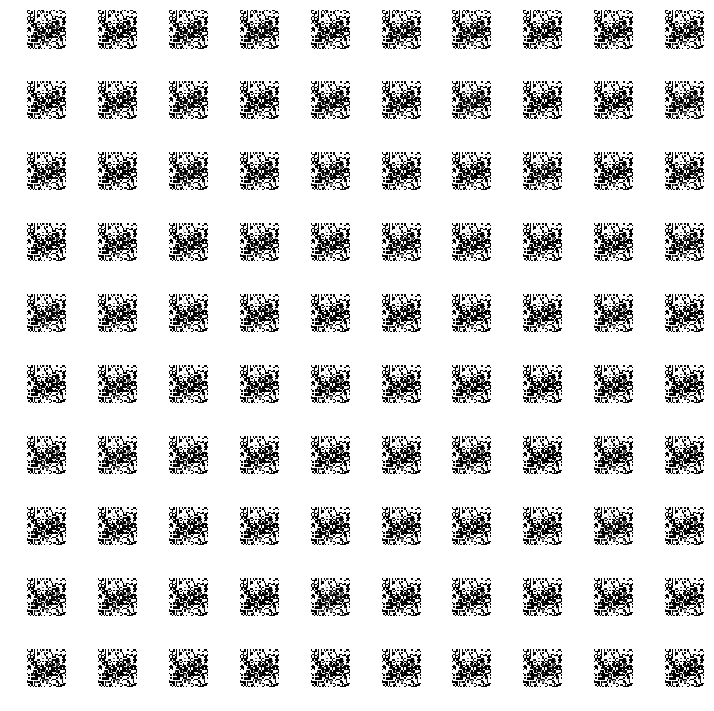

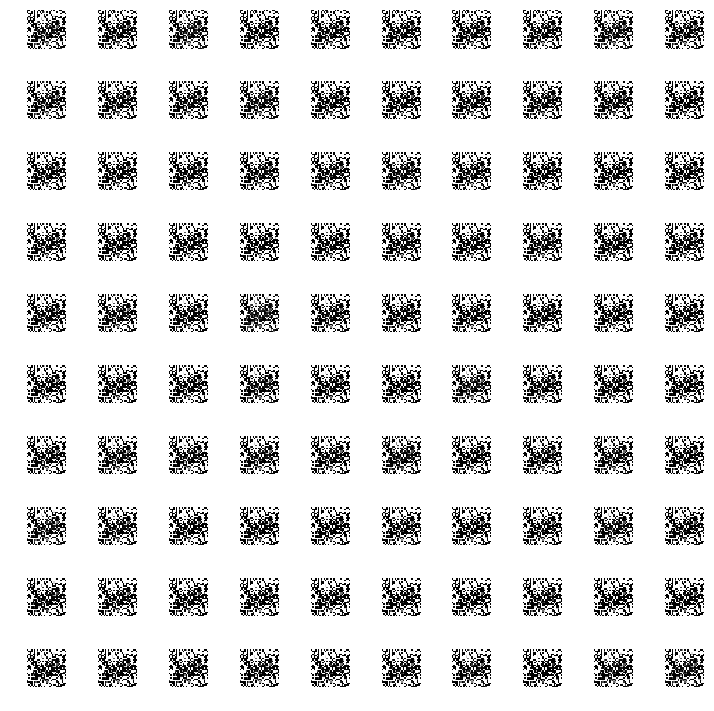

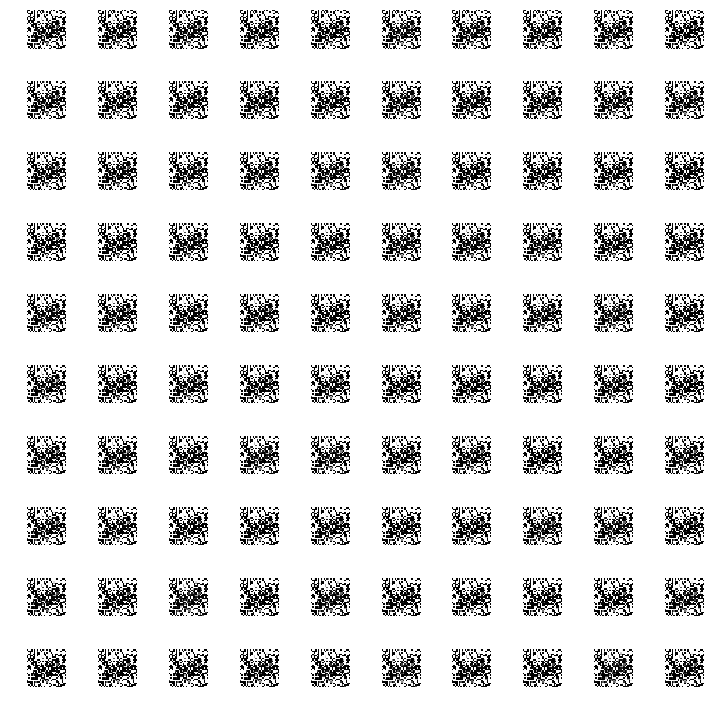

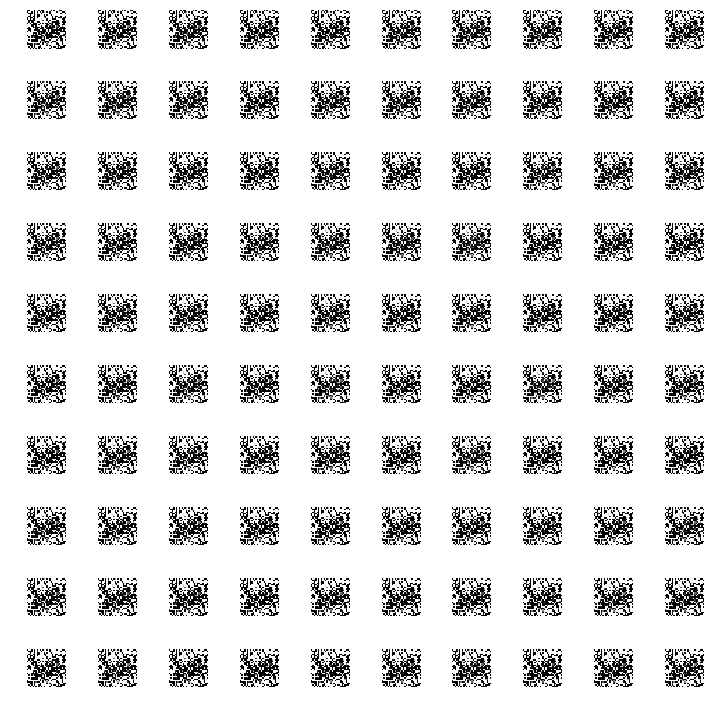

In [190]:
# Train the GAN!

for this_epoch in range(1, epochs+1):

    for _ in range(batch_num):
        # Generate random input noise and image
        noise = np.random.normal(0, 1, size=[batch_size, dimensionality])
        image_batch = X_train_arr[np.random.randint(0, X_train_arr.shape[0], size=batch_size)]
        
        # Generate fake image
        fake_image = generator.predict(noise)
        X = np.concatenate([image_batch, fake_image])
        
        # Labels for generated and real data
        yDis = np.zeros(2 * batch_size)
        # 1-sided label smoothing
        yDis[:batch_size] = 0.9
        
        # Train discriminator
        discriminator.trainable = True
        dloss = discriminator.train_on_batch(X, yDis)
        discriminator.trainable = False
        
        # Train generator
        noise = np.random.normal(0, 1, size=[batch_size, dimensionality])
        yGen = np.ones(batch_size)
#         discriminator.trainable = False
        gloss = gan.train_on_batch(noise, yGen)
    
    # Store loss of most recent batch from this epoch
    dLosses.append(dloss)
    gLosses.append(gloss)
    
#    Save model every 10 epochs
    if this_epoch == 1 or this_epoch % 50 == 0:
#         plotGeneratedImages(this_epoch)
        generator.save('./models/gan_generator_epoch_{}.h5'.format(this_epoch))
        discriminator.save('./models/gan_discriminator_epoch_{}.h5'.format(this_epoch))
        
        # Generated images
        noise = np.random.normal(0, 1, size=[100, dimensionality])
        generated_image = generator.predict(noise)
        generated_image = generated_image.reshape(100, 28, 28)
        
        plt.figure(figsize=(10,10))
        for i in range(generated_image.shape[0]):
            plt.subplot(10, 10, i+1)
            plt.imshow(generated_image[i], interpolation='nearest', cmap='gray_r')
            plt.axis('off')
        plt.tight_layout()
        plt.savefig('./images/GAN_generator_image_epoch{}'.format(this_epoch))
        print('Sanity check- current epoch: {}'.format(this_epoch))

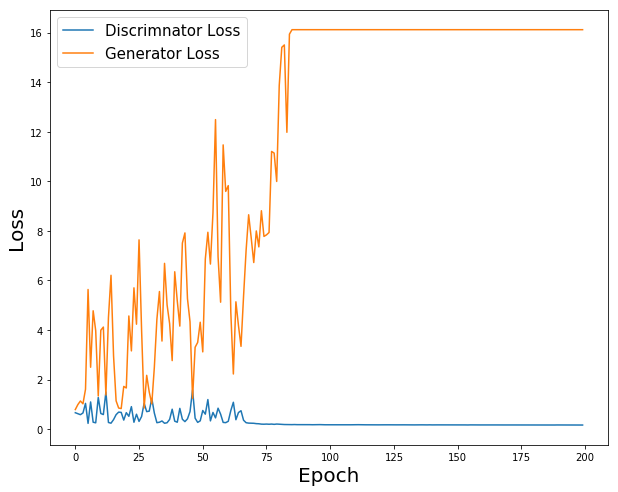

In [187]:
# Plot loss
plt.figure(figsize=(10,8))
plt.plot(dLosses, label='Discrimnator Loss')
plt.plot(gLosses, label='Generator Loss')
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.legend(fontsize=15)
plt.savefig('./loss/GAN_loss_epoch_{}'.format(this_epoch))